In [1]:
# import libraries here

import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 

In [2]:
def load_images(image_directory):
	# Get the list of image file names
	image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]

	# Initialize empty lists to store images and labels
	images = []
	labels = []
	
	for file_name in image_files :
		image_path = os.path.join(image_directory, file_name)
		
		image = Image.open(image_path)
		
		# Convert the image to a numpy array and append to the images list
		images.append(np.array(image))
		
		# Extract the label from the file name (assuming the label is the file name without the extension)
		label = file_name.split('_')[0]
		labels.append(label)
		
	return images, labels
	

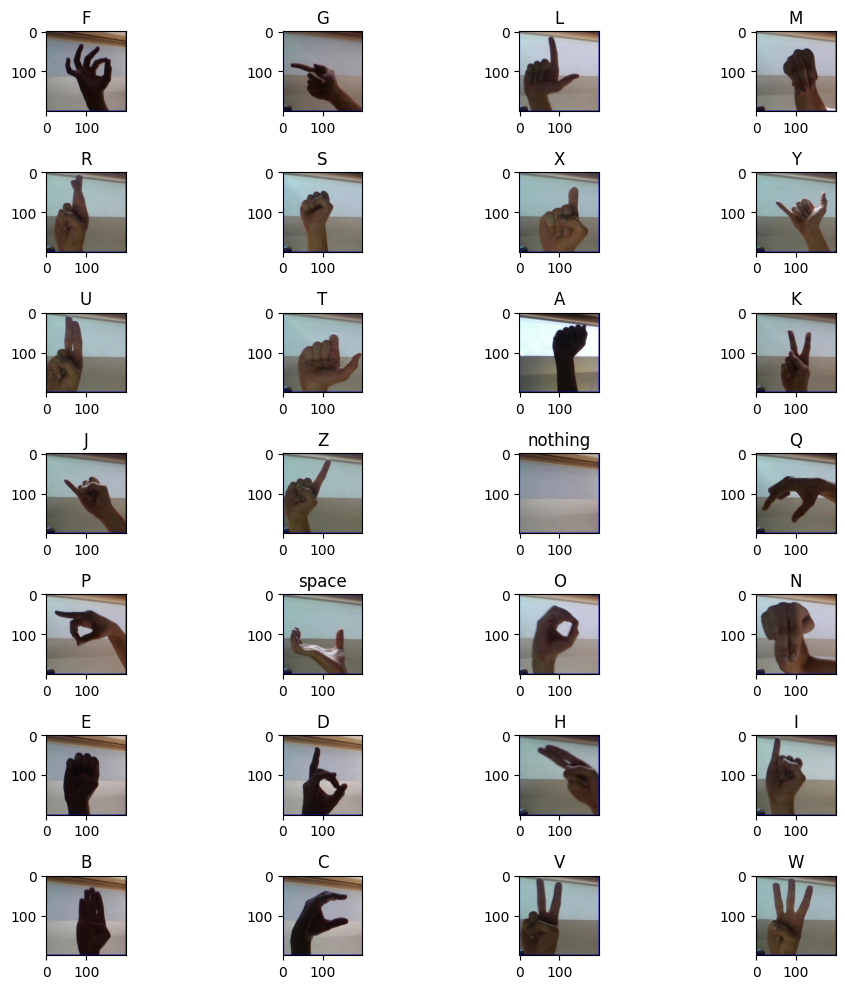

In [3]:
signs, labels = load_images("images")

plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(zip(signs, labels)):
	if i < 28:
		plt.subplot(7, 4, i + 1)
		plt.imshow(image)
		plt.title(label)
plt.tight_layout()
plt.show()

# Edge detection

To accomplish our inital goal of detecting sign language in images, we are first performing edge detection. Edges can be described in an image as pixel intensity staying the same along the edge directions. Applying a gaussian filter before detecting edges makes it easier to identify edges in an image. To find edges we are implementing the sobel edge detection method, and canny edge detection method.

## Sobel Edge Detection

This method uses the gradient in both $x$ and $y$ direction to find edges. 

When there is hardly any change in the $x$ direction this signifies and edge along the $y$ direction $$I_x = 0$$

Whereas, hardly any change in the $y$ direction signifies an edge along the $x$ direction $$I_y = 0$$

Finding the image gradients involves convolving the image with a sobel filter for the respective direction. The sobel filters are defined as

$$sobel_x = \begin{bmatrix}
	-1 & 0 & 1 \\
	-2 & 0 & 2 \\
	-1 & 0 & 1 \end{bmatrix}$$

$$sobel_y = \begin{bmatrix}
	1 & 2 & 1 \\
	0 & 0 & 0 \\
	-1 & -2 & -1 \end{bmatrix}$$

## Canny Edge Detection

The Canny edge detection method is a highly popular and most used method for finding edges. The four step process includes:

1. Noise Reduction - by applying a gaussian filter to reduce noise.
2. Calculating the Intensity Gradient of the Image - Finding the intensity gradient magnitude and direction of each pixel of the image.
$$G = \sqrt(G_x^2 + G_y^2)$$
$$\Theta = \arctan(G_x / G_y)$$
3. Suppression of False Edges - Compare pixels to their neighbors in the positive and negative gradient direction. If the gradient magnitude of the pixel is greater than its neighboring pixel it is left unchanged, otherwise it is set to zero.
4. Hysteresis Thresholding - The gradient magnitudes are then compared with two different threshold values.



https://learnopencv.com/edge-detection-using-opencv/




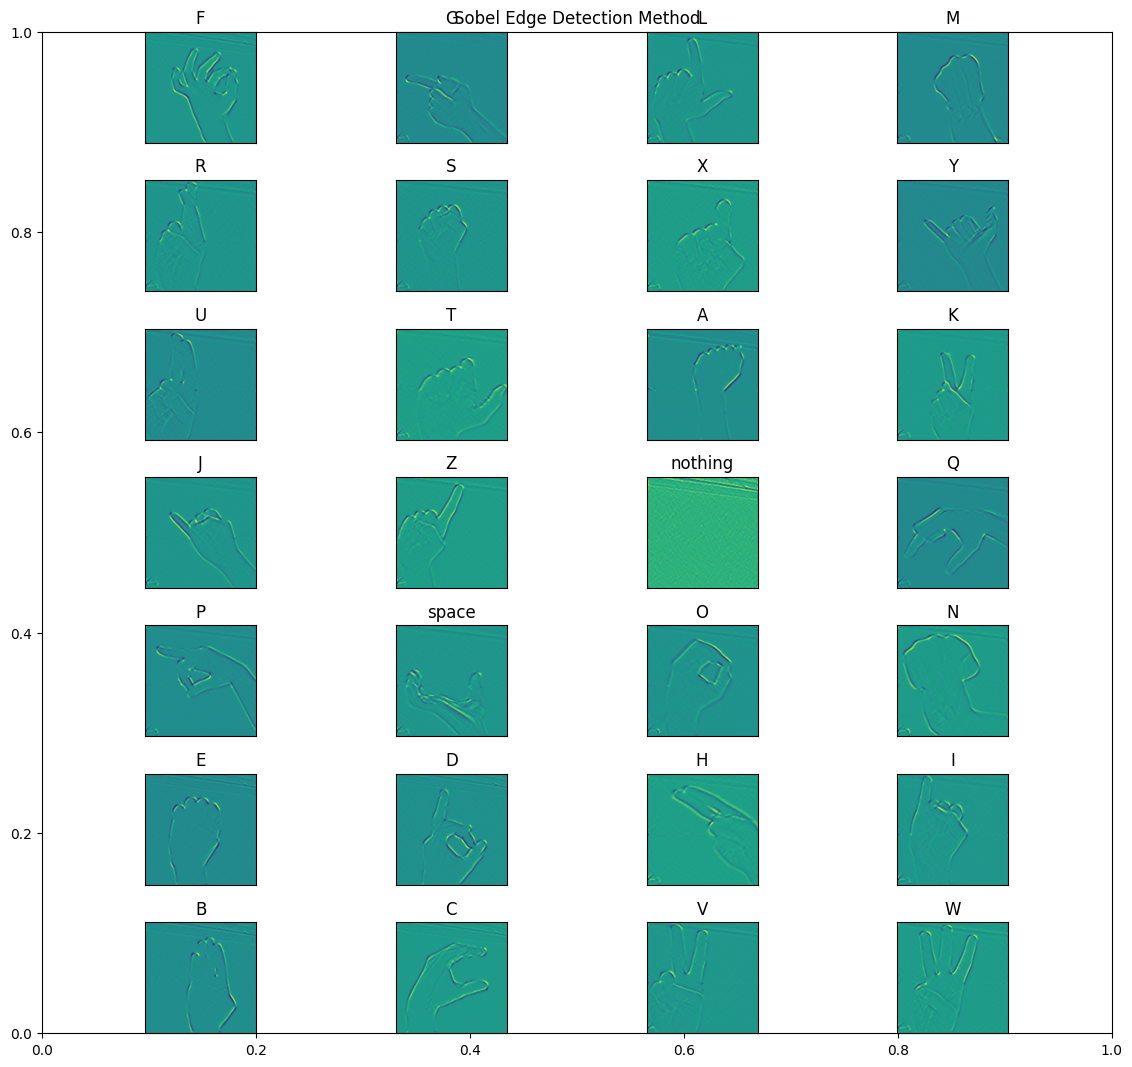

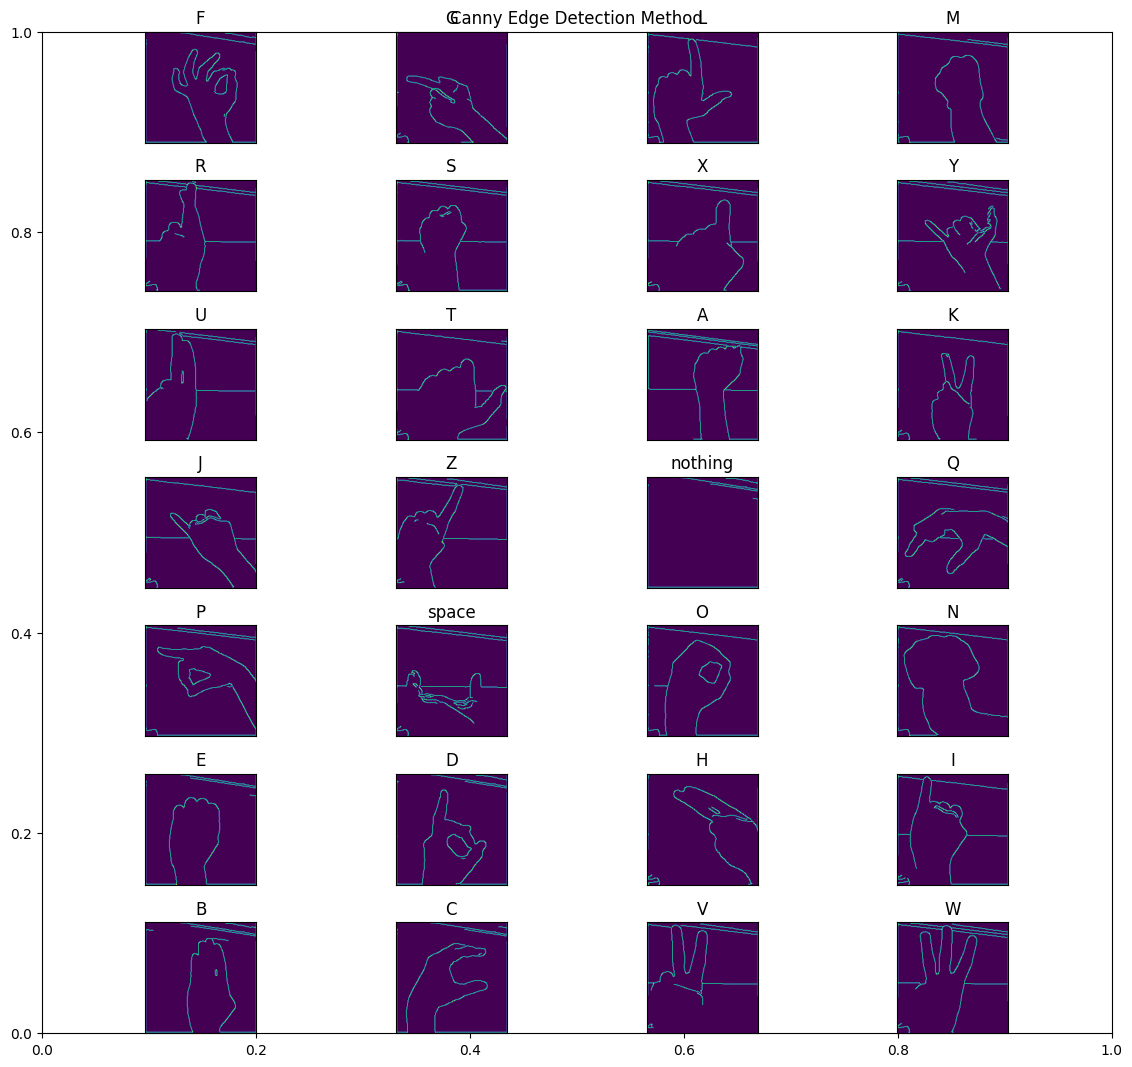

In [4]:
def sobel_edge(img):
	gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
	
	sobelxy = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
	
	return sobelxy

def canny_edge(img):
	gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
	
	canny_img = cv2.Canny(image=blur_img, threshold1=100, threshold2=200)
	
	return canny_img

sobel_imgs = []
canny_imgs = []

def plot_sobel_edge_imgs(signs,labels):
	plt.figure(figsize=(11,11))
	
	plt.title("Sobel Edge Detection Method")
	# need to find a way to show title more clearly
	
	for i, (image, label) in enumerate(zip(signs, labels)):
		sobel_img = sobel_edge(image)
		sobel_imgs.append(sobel_img)
		
		plt.subplot(7,4,i+1)
		plt.imshow(sobel_img)
		plt.title(label)
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])
	plt.tight_layout()
	plt.show()
	
def plot_canny_edge_imgs(signs,labels):
	plt.figure(figsize=(11,11))
	
	plt.title("Canny Edge Detection Method")
	# need to find a way to show title more clearly
	
	for i, (image, label) in enumerate(zip(signs, labels)):
		canny_img = canny_edge(image)
		canny_imgs.append(canny_imgs)
		
		plt.subplot(7,4,i+1)
		plt.imshow(canny_img)
		plt.title(label)
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])
	plt.tight_layout()
	plt.show()
		
plot_sobel_edge_imgs(signs,labels)
plot_canny_edge_imgs(signs,labels)



# Corner detection

Once we have found the edges using one of the edge detection methods, we can now find corners. Given a window to sweep an image, corners are found when there is a signicant change of pixel intersity in both the $x$ and $y$ coordinates. Our first implementation of edge detection is using the **Harris Corners** technique. 

The **Harris Corner Detection** is as follows:
1. Computing the gradient in both $x$ and $y$ directions.
2. Computing the $H$ Matrix from the gradients and a smoothing operation using a gaussian window filter.
3. Computing the scoring functions
4. Finding points with a large response (threshold $f$)
5. FInding local maxima of $f$ after thresholding.

The $H$ matrix is defined as:
$$ H = \begin{bmatrix} A & B \\ B & C \end{bmatrix} = \sum_{(x, y) \in W} w_{x, y} \begin{bmatrix}
I_x^2 & I_x I_y \\ I_x I_y & I_y^2
\end{bmatrix} $$

The scoring functions $f$ is defined as:
$$ f = min(\lambda_1, \lambda_2) $$
$$ f = \frac{\text{det}(H)}{\text{tr}(H)} $$



### ***References***
- https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html
- Professor Stein's lectures




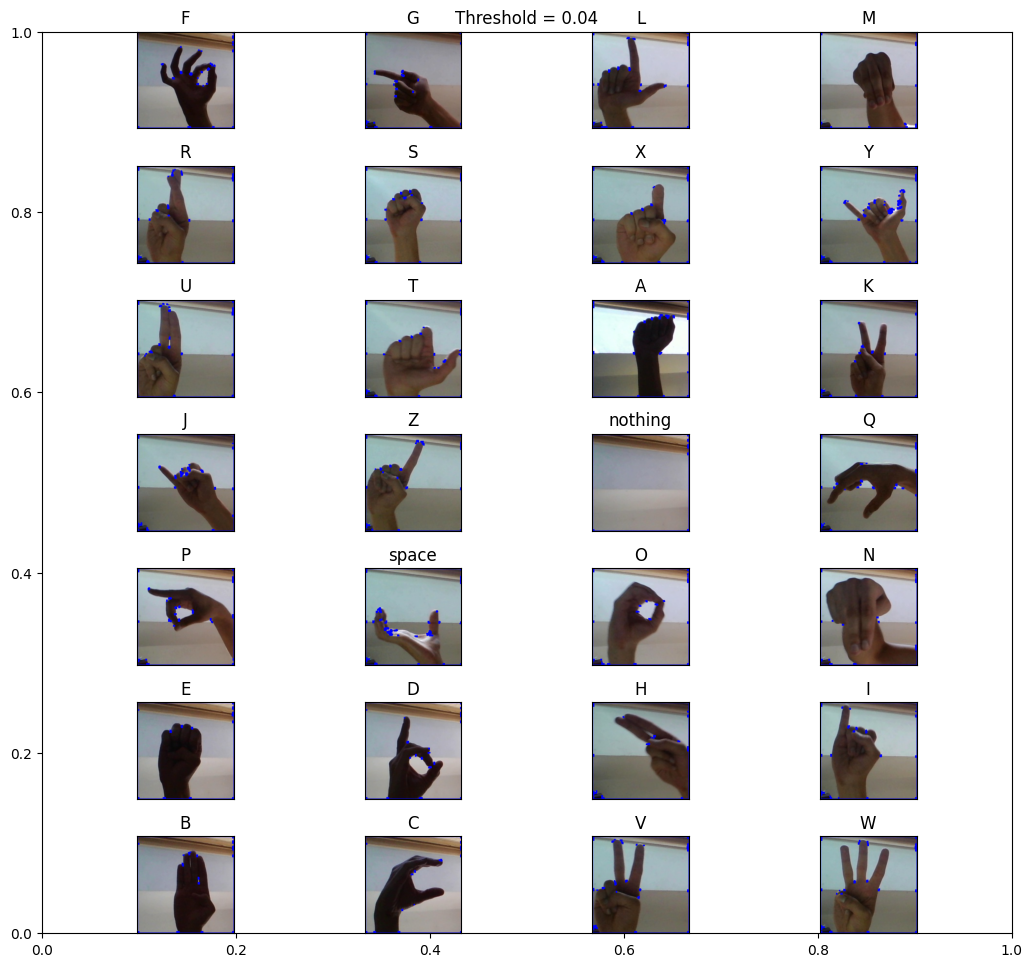

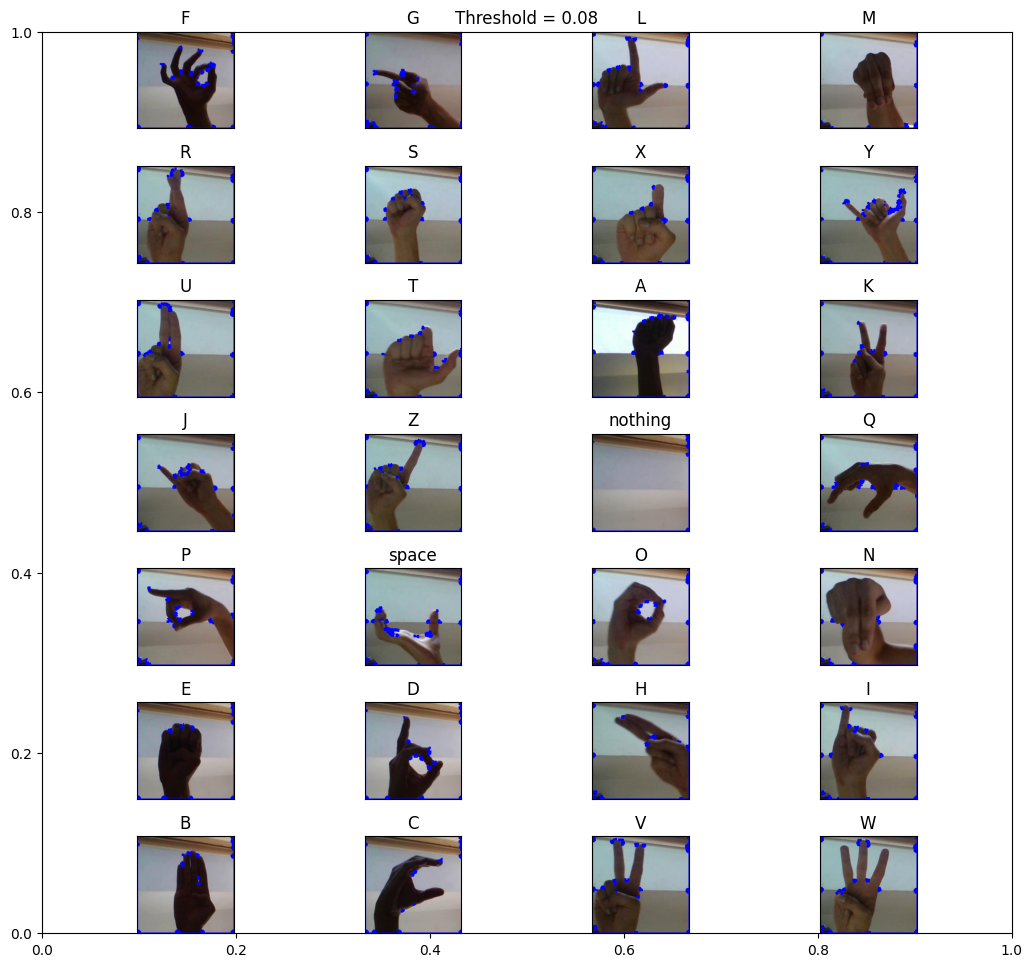

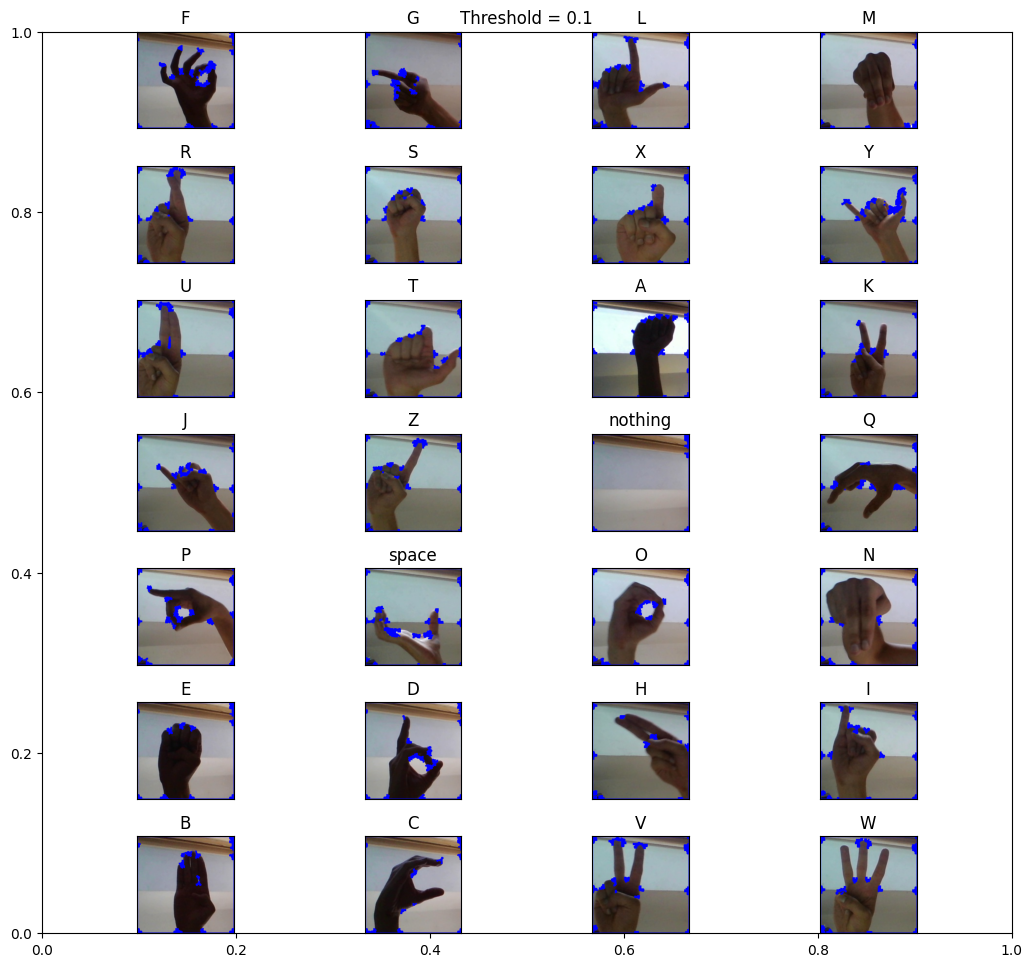

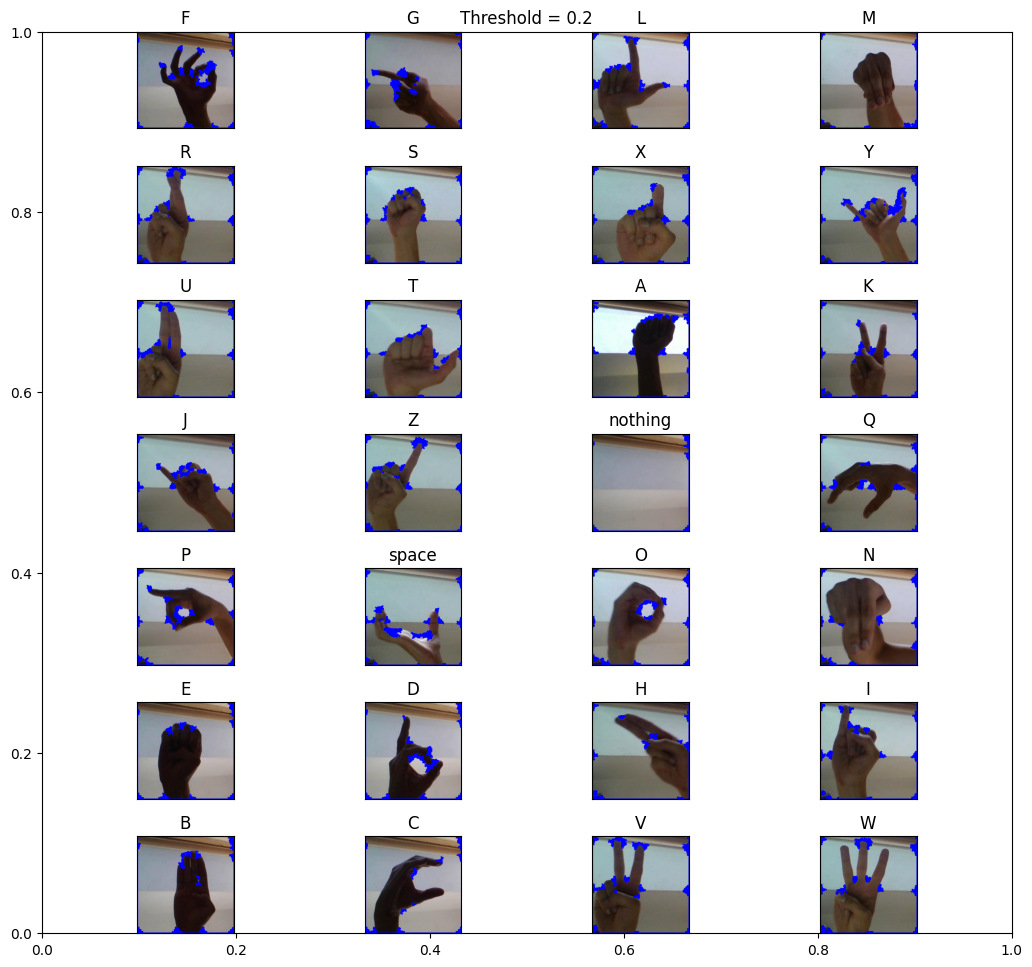

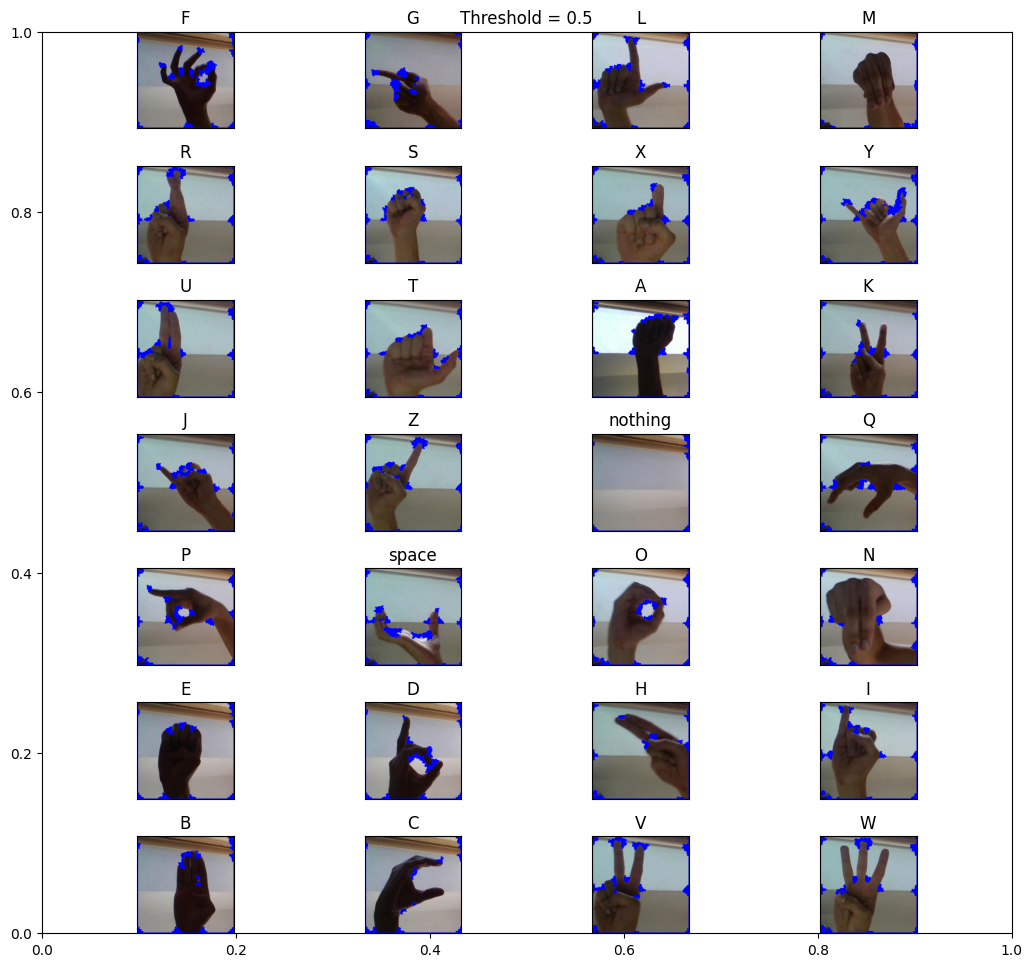

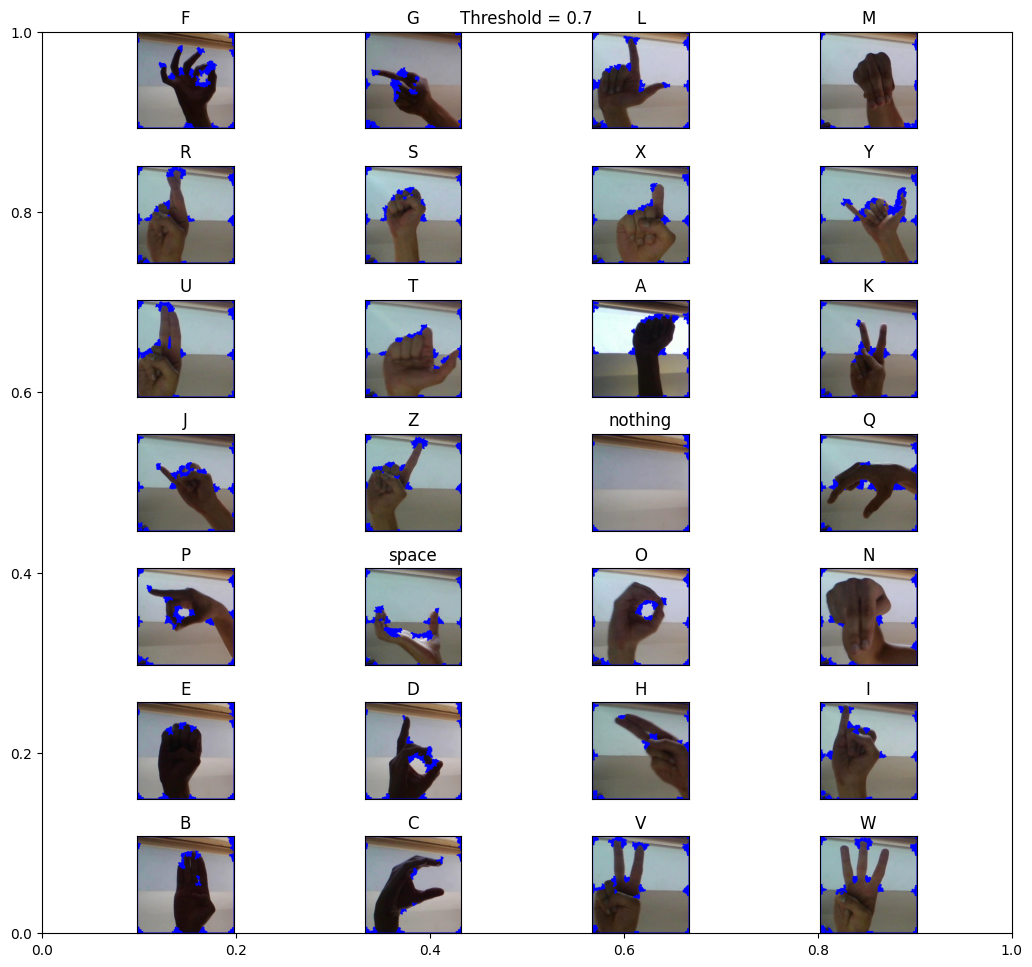

In [5]:
def harris_corner(img, threshold):
	gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	gray_img = np.float32(gray_img)
	harris_img = cv2.cornerHarris(gray_img,3,3,threshold)
 
	#result is dilated for marking the corners, not important
	harris_img = cv2.dilate(harris_img,None)
 
	# Threshold for an optimal value, it may vary depending on the image.
	img[harris_img>0.01*harris_img.max()]=[0,0,255]
	return img

def plot_harris_corners(signs,labels,threshold):
	plt.figure(figsize=(10,10))
	plt.title(f"Threshold = {threshold}")
	for i, (image, label) in enumerate(zip(signs, labels)):
		harris = harris_corner(image,threshold)
		plt.subplot(7,4,i+1)
		plt.imshow(harris)
		plt.title(label)
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])
	plt.tight_layout()
	plt.show()
	
different_thresholds = [0.04, 0.08, 0.1, 0.2, 0.5, 0.7]

for thresholds in different_thresholds:
	plot_harris_corners(signs,labels,thresholds)



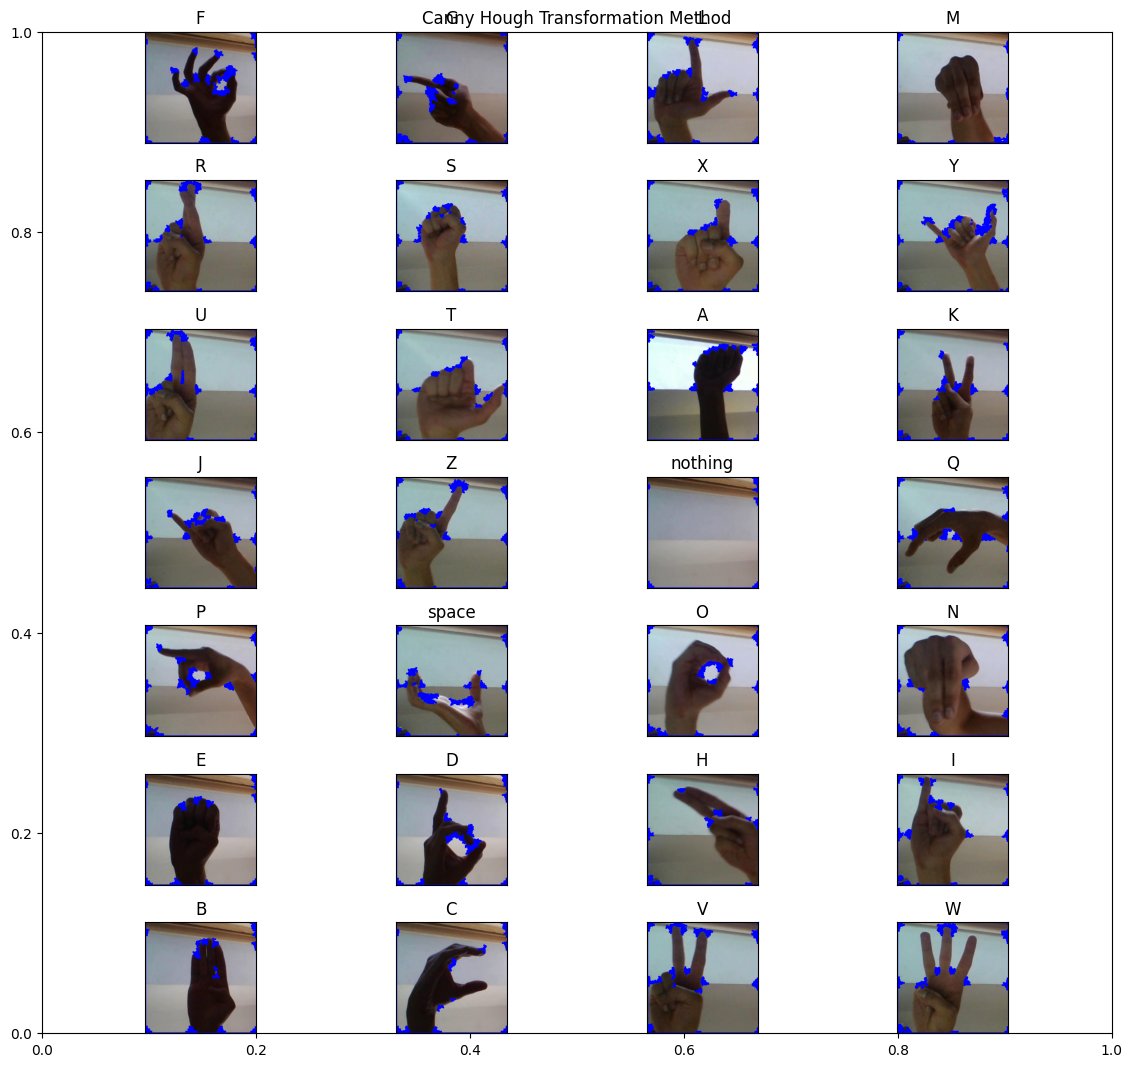

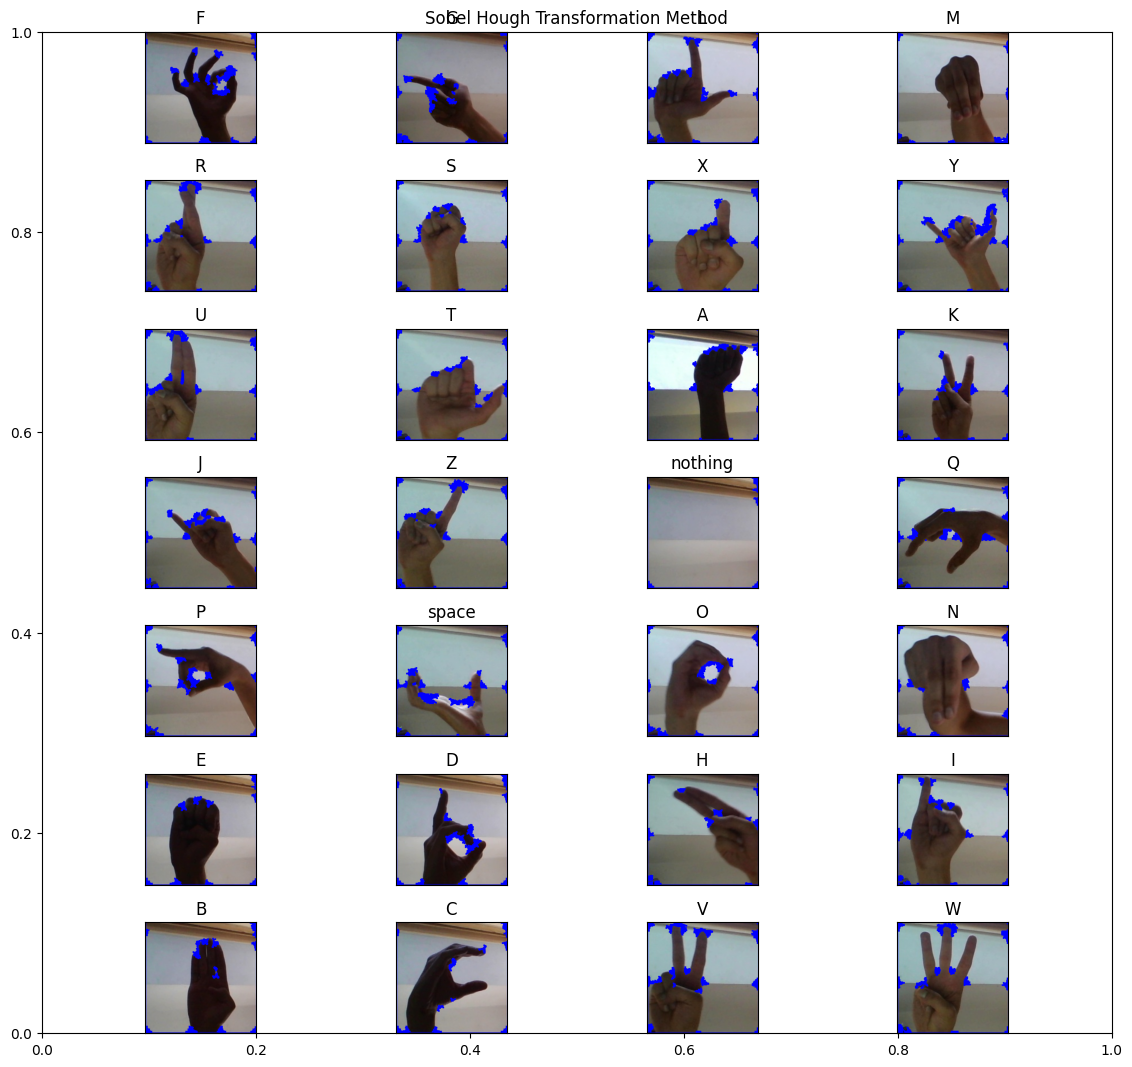

In [6]:
#Hough Transformation through Canny Edge detection

#list of canny hough images
canny_hough_imgs = []

#list of sobel hough images
sobel_hough_imgs = []

#canny hough transformation
def canny_hough_transfromation(image):

	#get the gray image
	g_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	#get the edge detection using canny
	canny_image = cv2.Canny(g_image, 50, 150, apertureSize=3)

	#get the hough lines
	image_lines = cv2.HoughLines(canny_image, 1,np.pi / 180, 200)

	#computing the lines
	if image_lines is not None:
		for line in image_lines:
	
			r, t = line[0]
			a = np.cos(t)
			b = np.sin(t)
			x = a * r
			y = b * r
			x1 = int(x + 1000 * (-b))
			y1 = int(y + 1000 * (a))
			x2 = int(x - 1000 * (-b))
			y2 = int(y - 1000 * (a))
	
			cv2.line(image, (x1,y1), (x2,y2), (0,0,255), 2)

	return image

#sobel hough transformation
def sobel_hough_transfromation(image):

	#get the gray image
	g_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	#get the edge detection using sobel
	sobel_img = np.uint8(cv2.magnitude(cv2.Sobel(g_image, cv2.CV_64F, 1, 0, ksize = 3), cv2.Sobel(g_image, cv2.CV_64F, 0, 1, ksize = 3)))
	
	#for sobel unlike canny I had to get the binary image
	#this the reason canny is known to be a better solution for hough transfromation
	_,sobel_image = cv2.threshold(sobel_img, 50, 255, cv2.THRESH_BINARY)

	#get the hough lines
	image_lines = cv2.HoughLines(sobel_image, 1,np.pi / 180, 200)

	#compute the lines
	if image_lines is not None:
		for line in image_lines:
	
			r, t = line[0]
			a = np.cos(t)
			b = np.sin(t)
			x = a * r
			y = b * r
			x1 = int(x + 1000 * (-b))
			y1 = int(y + 1000 * (a))
			x2 = int(x - 1000 * (-b))
			y2 = int(y - 1000 * (a))
	
			cv2.line(image, (x1,y1), (x2,y2), (0,0,255), 2)

	return image

#plot the canny images
def plot_canny_hough_imgs(signs,labels):
	plt.figure(figsize=(11,11))
	
	plt.title("Canny Hough Transformation Method")

	for i, (image, label) in enumerate(zip(signs, labels)):
	
		hough_image = canny_hough_transfromation(image)
		canny_hough_imgs.append(hough_image)
		
		plt.subplot(7,4,i+1)
		plt.imshow(hough_image)
		plt.title(label)
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])
		
	plt.tight_layout()
	plt.show()

#plot the sobel images
def plot_sobel_hough_imgs(signs,labels):
	plt.figure(figsize=(11,11))
	
	plt.title("Sobel Hough Transformation Method")
	# need to find a way to show title more clearly
	
	for i, (image, label) in enumerate(zip(signs, labels)):
	
		hough_image = sobel_hough_transfromation(image)
		sobel_hough_imgs.append(hough_image)
		
		plt.subplot(7,4,i+1)
		plt.imshow(hough_image)
		plt.title(label)
		plt.gca().set_xticks([])
		plt.gca().set_yticks([])
		
	plt.tight_layout()
	plt.show()

#plot the images
plot_canny_hough_imgs(signs,labels)
plot_sobel_hough_imgs(signs,labels)

# Bag of Words Imeplementation



In [7]:
"""
This function takes a list of images and extracts the features and descriptions of each image
using SIFT. It iterates over to each image, convert them to gray scale and uses sift to detect and 
compute desciptors and features.
"""

def feature_extracts(images):
	sift = cv2.SIFT_create()
	feats = []
	descriptors = []

	for img in images:
		if len(img.shape) == 3:
			gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		else: 
			gray_image = img
		
		
		gray_image = np.uint8(gray_image)
		
		_, descript = sift.detectAndCompute(gray_image, None)
		
		if descript is not None:
			feats.append(img)
			descriptors.append(descript)

	return feats, descriptors

"""
Performs clustering on a set of descriptors using K-means clustering in order to create a vocabulary.
It stacks the descriptors into a 1D array and applies the kmean clustering based on the k_num that was 
passed in. This creates a visual vocabulary for each image.
"""

def cluster(descriptors, k_num):
	
	descriptors_stack = np.vstack(descriptors)
	k_means = KMeans(n_clusters=k_num)
	k_means.fit(descriptors_stack)
	
	return k_means

"""
This functions takes the k_means that were created for each image and represents them in a histogram form.
each matching description increases that value in the bar graph. k_mean predict, predicts the closest cluster
each sample in X belongs to.

in the from sklearn.cluster import KMeans package for reference
Website: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
""" 
def histogram_rep(images, descriptors, k_mean):
	histograms = []
	
	for descript, img in zip(descriptors, images):
		histo = np.zeros(len(k_mean.cluster_centers_))
		des = k_mean.predict(descript)
		for d in des:
			histo[d] += 1
		histograms.append(histo)
	
	return histograms

#plots the histogram of each letter.

def plot_histograms(images, histograms, labels):
	num_images = len(images)
	num_rows = (num_images + 1) // 2  # Calculate the number of rows needed
	
	fig, axs = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows), gridspec_kw={'hspace': 0.5})  # Create subplots
	
	for i in range(num_images):
		row = i // 2
		col = i % 2
		axs[row, col].bar(range(len(histograms[i])), histograms[i])
		axs[row, col].set_title("Histogram for Letter: " + labels[i])
		axs[row, col].set_xlabel("Visual Word Index")
		axs[row, col].set_ylabel("Number of Occurrences")

	plt.show()

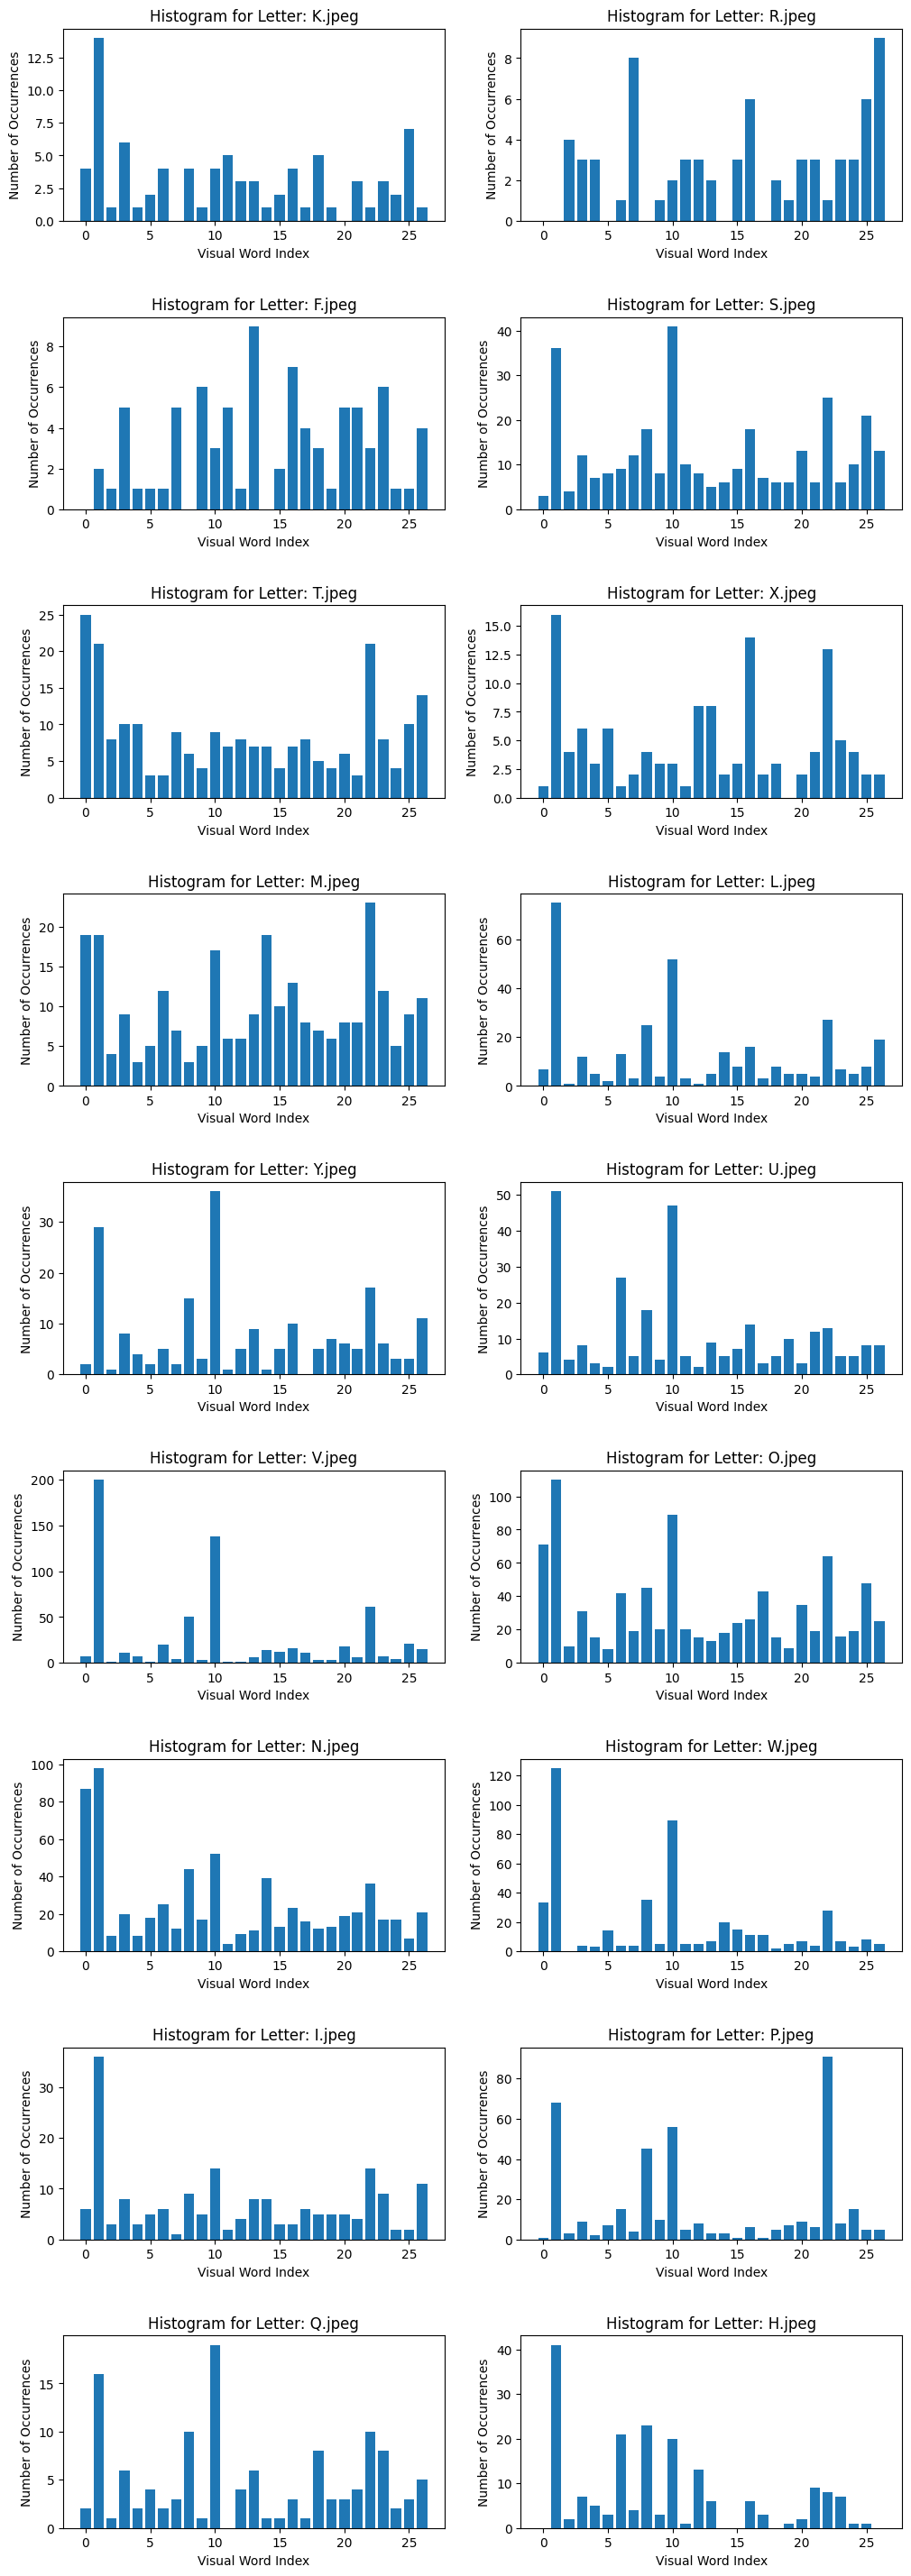

In [24]:
signs, labels = load_images("bjorn_images")
BoW_images = []

for i in signs:
	#BoW_images.append(sobel_edge(i))
	#BoW_images.append(canny_edge(i))
	#BoW_images.append(harris_corner(i, 0.5))
	BoW_images.append(canny_hough_transfromation(i))
	#BoW_images.append(sobel_hough_transfromation(i))

sign_feats, sign_descripts = feature_extracts(BoW_images)
k = cluster(sign_descripts, 27)
sign_histogram = histogram_rep(signs, sign_descripts, k)

plot_histograms(signs, sign_histogram, labels)

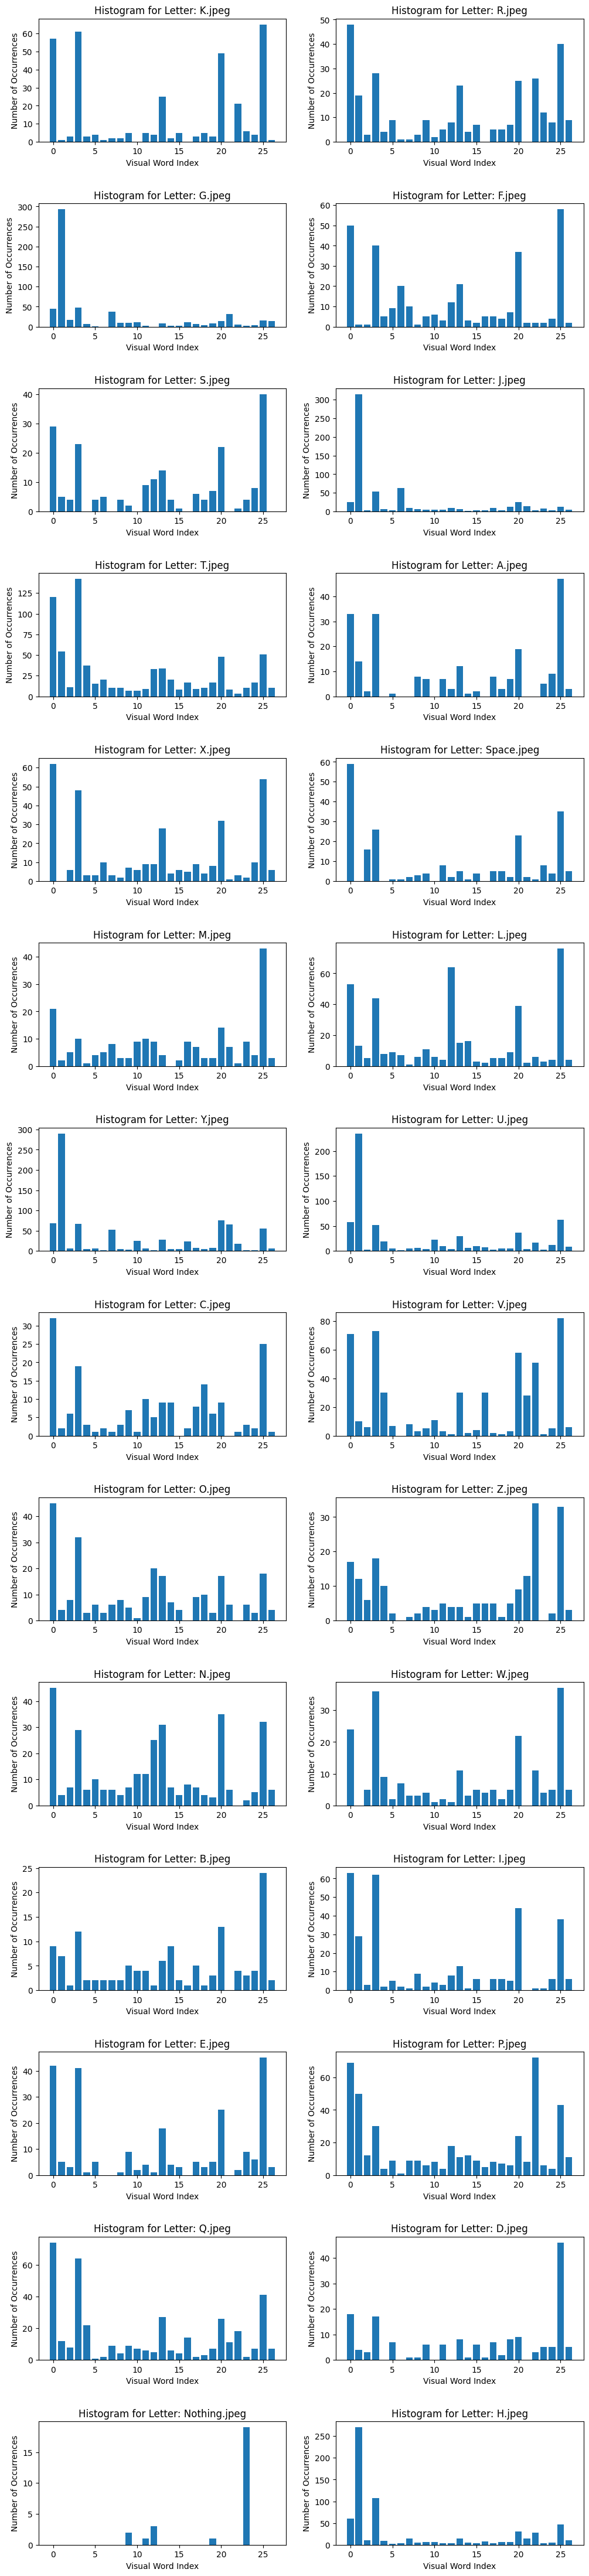

Test image K.jpeg is mapped to letter T.jpeg
Test image R.jpeg is mapped to letter T.jpeg
Test image G.jpeg is mapped to letter V.jpeg
Test image F.jpeg is mapped to letter T.jpeg
Test image S.jpeg is mapped to letter T.jpeg
Test image J.jpeg is mapped to letter V.jpeg
Test image T.jpeg is mapped to letter N.jpeg
Test image A.jpeg is mapped to letter T.jpeg
Test image X.jpeg is mapped to letter T.jpeg
Test image Space.jpeg is mapped to letter T.jpeg
Test image M.jpeg is mapped to letter K.jpeg
Test image L.jpeg is mapped to letter T.jpeg
Test image Y.jpeg is mapped to letter V.jpeg
Test image U.jpeg is mapped to letter W.jpeg
Test image C.jpeg is mapped to letter T.jpeg
Test image V.jpeg is mapped to letter T.jpeg
Test image O.jpeg is mapped to letter T.jpeg
Test image Z.jpeg is mapped to letter T.jpeg
Test image N.jpeg is mapped to letter T.jpeg
Test image W.jpeg is mapped to letter T.jpeg
Test image B.jpeg is mapped to letter K.jpeg
Test image I.jpeg is mapped to letter T.jpeg
Test i

In [26]:
Test_signs, Test_labels = load_images('Train_Images')

BoW_test = []

for i in Test_signs:
    BoW_test.append(canny_hough_transfromation(i))

test_feats, test_descripts = feature_extracts(BoW_test)
k = cluster(test_descripts, 27)

test_histogram = histogram_rep(Test_signs, test_descripts, k)
plot_histograms(Test_signs, test_histogram, Test_labels)
for i, test_hist in enumerate(test_histogram):
    min_distance = float('inf')
    predicted_label = None
    for j, train_hist in enumerate(sign_histogram):
        distance = np.abs(np.linalg.norm(train_hist - test_hist))
        if distance < min_distance:
            min_distance = distance
            predicted_label = labels[j]  # Corresponding label from training images
    print(f"Test image {Test_labels[i]} is mapped to letter {predicted_label}")
